In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

# Сравнение групп

При выполнении статистического анализа часто встречается задача сравнения групп. Предметом исследований может быть реакция пациентов на прием определенного лекарства, сокращение дорожно-транспортных происшествий после ввода в эксплуатацию новой системы регулирования движения, эффективность работы студентов при использовании различных методик обучения и т. д.

Вместо выполнения проверок гипотез мы выберем другой путь и сосредоточимся на оценке размера эффекта (effect size), то есть на количественной оценке различий между двумя группами. 

Определим размер эффекта (effect size) – как способ числовой оценки размера различий между двумя группами.

Преимуществом подхода с использованием размера эффекта является отказ от типа вопросов, требующих ответов (да/нет; действует ли это? возникает ли какой-либо эффект?), – и переход к более точным вопросам типа: насколько хорошо это действует? насколько велик/мал эффект?


ногда при сравнении групп говорят о контрольной группе и об экспериментальной группе (возможно существование нескольких контрольных и экспериментальных групп). Например, это имеет смысл, когда необходимо проверить действие нового лекарства: чтобы исключить эффект плацебо и другие факторы, необходимо сравнить процесс лечения с применением нового препарата с контрольной группой (которая не принимает этот препарат). <br>
В этом случае непременно нужно знать, насколько эффективно действует конкретное лекарство по сравнению с отсутствием действия каких-либо лекарств (или, если обобщить, по сравнению с эффектом плацебо). Здесь возникает важный альтернативный вопрос: насколько эффективно новое лекарство по сравнению с уже апробированным наиболее широко применяемым препаратом для лечения данной болезни. <br>
В этом случае контрольной группой не может быть плацебо, в ней должно тестироваться другое лекарство. Фиктивные контрольные группы – прямой путь ко лжи с использованием статистики.

Например, предположим, что вы работаете в компании, производящей молочные продукты, которая планирует начать продажи йогуртов с высоким содержанием сахара для детей, убеждая их родителей в том, что этот конкретный йогурт укрепляет иммунную систему или способствует быстрому росту. Одним из способов обмана и фальсификации для обоснования таких утверждений являются данные, полученные при использовании молока или даже воды в качестве контрольной группы вместо другого, более дешевого, менее «раскрученного» йогурта с низким содержанием сахара. 

Дейстаительно смешно, но огромное количество реальных исследований выполняется именно таким способом. 

Когда кто-то заявляет о том, что некий объект или продукт прочнее, лучше, быстрее, долговечнее, не забудьте уточнить, на какой основе выполнялось сравнение.

<b>Как же мы будем сравнивать группы?</b>

Для сравнения групп необходимо выбрать признак или несколько признаков, по которым будет производиться сравнение. Наиболее часто выбираемым признаком является среднее значение каждой группы. 

Поскольку мы занимаемся байесовским анализом, будем пытаться получить апостериорное распределение различий в средних значениях между группами, а не только точечную оценку различий. 

Для визуального наблюдения и интерпретации такого апостериорного распределения воспользуемся тремя инструментами:
<ol> 
    <li>график апостериорного распределения с эталонным значением;</li>
<li>d-мера Коэна;</li>
<li>вероятность превосходства.</li>
</ol>   

Как раз в предыдущем примере мы рассматривали пример с использованием функции 
<code>az.plot_posterior</code> с эталонным значением, другой пример мы сейчас рассмотрим.

### d-мера Коэна (мера эффекта)

Общепринятым способом измерения размера эффекта является d-мера Коэна,
определяемая следующей формулой:
$$ d = \dfrac{\mu_2-\mu_1}{\sigma_U} = \dfrac{\mu_2-\mu_1}{\sqrt{\cfrac{\sigma^2_2 + \sigma^2_1}{2}}}$$

В соответствии с этой формулой размер эффекта является разностью средних значений, разделенной на объединенное стандартное отклонение для обеих групп. 
Так как можно получить апостериорное распределение средних значений и стандартных отклонений, можно также вычислить апостериорное распределение значений d-меры Коэна. 

Разумеется, если необходимо всего лишь одно значение, то можно вычислить среднее значение этого апостериорного распределения и получить единственное значение d-меры Коэна.

В общем случае при вычислении объединенного стандартного отклонения явно учитывается размер выборки каждой группы, но в формулу размеры выборок для групп не включены. Причина в том, что значения стандартного отклонения выводятся из апостериорного распределения, следовательно, неопределенность стандартных отклонений для каждой группы уже учтена.

d-мера Коэна вводит свойство вариации для каждой группы, используя стандартные отклонения этих групп. Это действительно важно, поскольку одинаковые различия при стандартном отклонении 0.1 выглядят большими по сравнению с теми же различиями при стандартном отклонении 10. Кроме того, изменение на $x$ единиц в одной группе по отношению к другой может быть объяснено как изменение в точности на $x$ единиц каждой отдельной точки данных, или как изменение половины точек данных на $2x$ единиц, тогда как другая половина не изменилась, или множеством других возможных вариантов. 

Таким образом, включение внутренних вариаций групп – это способ размещения различий в контексте. Изменение масштаба (нормализация) различий помогает правильно оценить важность конкретных различий между группами, даже если точно неизвестен коэффициент масштаба, используемый при измерениях.


Принято определять размер эффекта как указано в таблице добавля позитивный или негативный в зависимости от знака.

| размер эффекта   |      d      |  Ссылка |
|:----------|---------------|------:|
| Очень маленький |  0.01 | Sawilowsky, 2009 |
| Маленький   | 0.2 | Cohen, 1988 |
| Средний     | 0.5 | Cohen, 1988 |
| Большой      | 0.8 | Cohen, 1988 |
| Очень большой | 1.2 | Sawilowsky, 2009 |
| Огромный | 2.0 | Sawilowsky, 2009| 


### Вероятность превосходства

Это альтернативный метод описания размера эффекта, который определяется как вероятность того, что точка данных, выбранная случайным образом из одной группы, имеет большее значение, чем точка данных, также случайным образом выбранная из другой группы. Если предположить, что распределение исследуемых данных является нормальным, то можно вычислить вероятность превосходства по d-мере Коэна, используя следующую формулу:

$$ p =  \Phi \left( \frac{\delta}{\sqrt{2}} \right) $$

Здесь $\Phi$ – cdf-функция нормального распределения, $\delta$ – d-мера Коэна. 

Можно также вычислить точечную оценку вероятности превосходства (которую обычно и указывают в отчетах) или полное апостериорное распределение значений. Если мы с уверенностью формулируем предположения о нормальности, то можем использовать эту формулу для получения вероятности превосходства по d-мере Коэна. 
Но поскольку мы располагаем выборками из апостериорного распределения, можно напрямую вычислять вероятность превосходства

### Набор чаевые (tips)

Для демоснтрации будем использовать набор данных tips.

Необходимо исследовать влияние дня недели на сумму чаевых, оставляемых посетителями ресторана. В этом примере различными группами являются дни недели. 

Особо отметим отсутствие контрольной группы и экспериментальной группы. При необходимости можно установить один день, например четверг, как эталонную или контрольную группу.

In [2]:
tips = sns.load_dataset("tips")
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


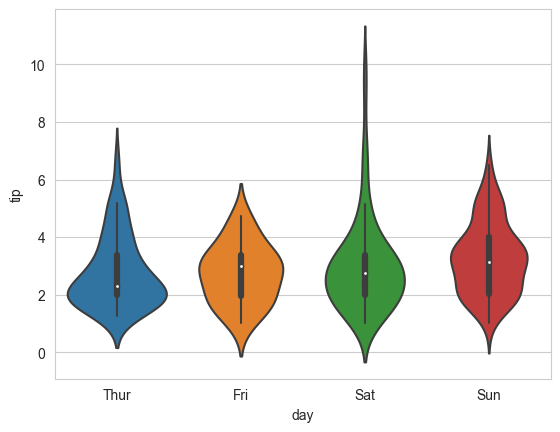

In [3]:
sns.violinplot(x='day', y='tip', data=tips);

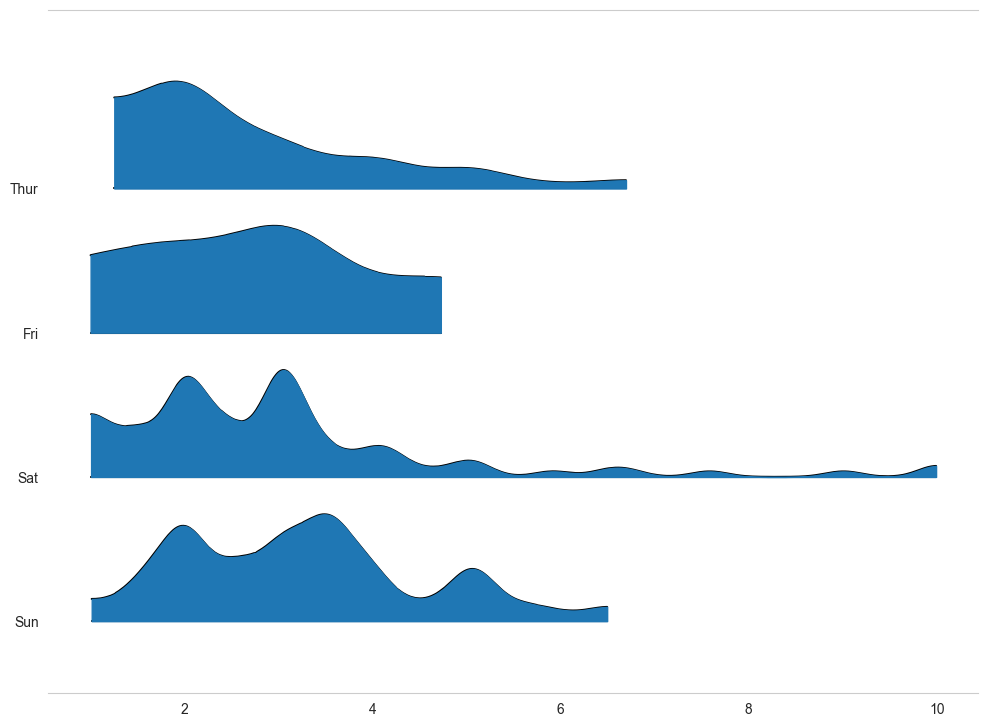

In [4]:
az.plot_forest(tips.pivot(columns='day', values='tip').to_dict('list'),
               kind='ridgeplot',
               hdi_prob=1);

In [5]:
tips.pivot(columns='day', values='tip').to_dict('list')

{'Thur': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  4.0,
  3.0,
  2.71,
  3.0,
  3.4,
  1.83,
  5.0,
  2.03,
  5.17,
  2.0,
  4.0,
  5.85,
  3.0,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  1.5,
  1.8,
  2.92,
  2.31,
  1.68,
  2.5,
  2.0,
  2.52,
  4.2,
  1.48,
  2.0,
  2.0,
  2.18,
  1.5,
  2.83,
  1.5,
  2.0,
  3.25,
  1.25,
  2.0,
  2.0,
  2.0,
  2.7

Для упрощения создадим три переменные: 
* y - представляющую набор данных tips, 
* idx – категориальную фиктивную переменную для кодирования дней недели с помощью чисел, то есть [0,1,2,3] вместо [четверг, пятница, суббота, воскресенье], а также переменную 
* groups - содержащую количество групп

In [6]:
categories = ['Thur', 'Fri', 'Sat', 'Sun']

tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=categories).codes
groups = len(np.unique(idx))

Модель для этой задачи почти та же, как и предидущие модели. Единственное различие заключается в том, что здесь $\mu$ и $\sigma$ должны быть векторами, а не скалярными переменными. При таких условиях синтаксис PyMC чрезвычайно удобен: вместо циклов <code>for</code> можно записать используемую здесь модель в векторизованной форме. Это означает, что для априорных распределений передается аргумент <code>shape</code>, а для функции правдоподобия соответствующим образом индексируются переменные <code>means</code> и <code>sd</code> с использованием переменной <code>idx</code>:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 28 seconds.
Sampling: [y]


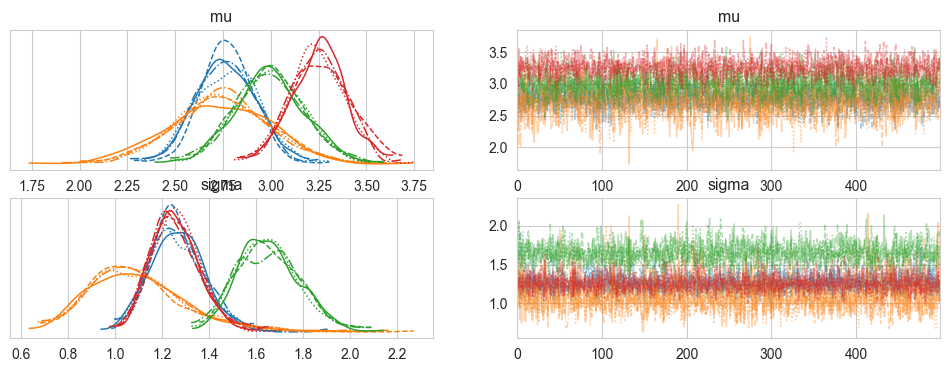

In [7]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('mu', mu=0, sigma=10, shape=groups)
    σ = pm.HalfNormal('sigma', sigma=10, shape=groups)
    
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=tip)
    trace_cg = pm.sample(500)
    
    trace_cg.extend(pm.sample_posterior_predictive(trace_cg))# упакуем допник ...
    
az.plot_trace(trace_cg);

Приведенный ниже код представляет только один из способов графического отображения различий без повторения операции сравнения. 

Вместо вывода содержимого матрицы «все против всех» строится график только ее верхней треугольной части:

In [8]:
trace_cg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [9]:
posterior_cg = trace_cg.posterior.stack(samples={"chain", "draw"})
posterior_cg

<xarray.Dataset>
Dimensions:      (mu_dim_0: 4, samples: 2000, sigma_dim_0: 4)
Coordinates:
  * mu_dim_0     (mu_dim_0) int64 0 1 2 3
  * sigma_dim_0  (sigma_dim_0) int64 0 1 2 3
  * samples      (samples) object MultiIndex
  * draw         (samples) int64 0 0 0 0 1 1 1 1 ... 498 498 498 499 499 499 499
  * chain        (samples) int64 0 1 2 3 0 1 2 3 0 1 2 ... 1 2 3 0 1 2 3 0 1 2 3
Data variables:
    mu           (mu_dim_0, samples) float64 2.533 2.912 3.06 ... 3.111 3.425
    sigma        (sigma_dim_0, samples) float64 1.355 1.256 ... 1.169 1.293
Attributes:
    created_at:                 2023-09-11T23:04:07.514824
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              27.668968200683594
    tuning_steps:               1000

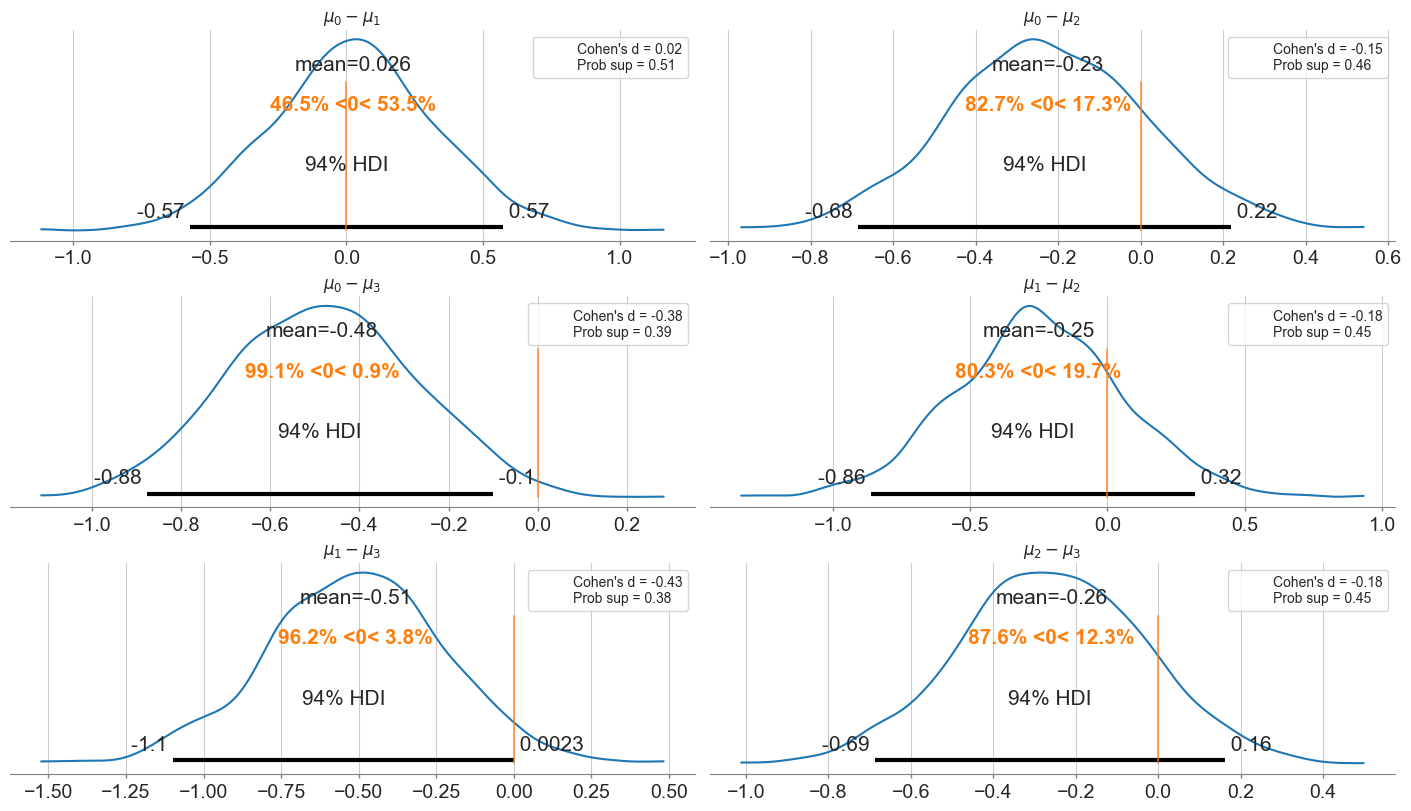

In [10]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

posterior_cg = trace_cg.posterior.stack(samples={"chain", "draw"})

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = posterior_cg["mu"].sel({"mu_dim_0":i}) - posterior_cg["mu"].sel({"mu_dim_0":j})
    d_cohen = (means_diff / np.sqrt((posterior_cg["sigma"].sel({"sigma_dim_0":i})**2 + 
                                     posterior_cg["sigma"].sel({"sigma_dim_0":j})**2) / 2)).mean().item()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()

Один из способов интерпретации полученных результатов – сравнение эталонного значения с интервалом плотности апостериорного распределения (ПАР). 

В соответствии с графиками на схеме наблюдается только один случай, когда из интервала ПАР 94 % исключено эталонное значение, равное нулю, то есть существует различие в суммах чаевых между четвергом (Thursday) и воскресеньем (Sunday). 

Для всех остальных примеров невозможно исключить вероятность нулевого различия (по критерию перекрытия ПАР и эталонного значения). Но даже в этом случае можно ли считать различие приблизительно в 0.5 доллара довольно большим? 

Достаточно ли существования такого различия, чтобы работать в воскресенье, лишившись возможности провести время с семьей или с друзьями? 

Достаточно ли велико это различие для того, чтобы выровнять среднюю сумму чаевых по рассматриваемым четырем дням и оставлять каждому официанту одинаковую сумму чаевых? 

На вопросы такого рода невозможно ответить с помощью статистики, поскольку статистика всего лишь предоставляет определенную (числовую) информацию.

Новая версия кода ...

In [32]:
categories = np.array(['Thur', 'Fri', 'Sat', 'Sun'])
tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=categories).codes
idx

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0], dtype=int8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [y]


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

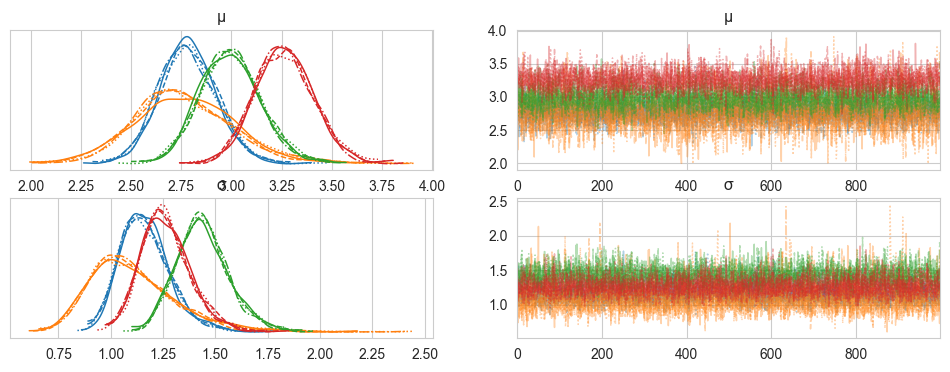

In [24]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal('μ', sigma=5, dims="days")
    σ = pm.HalfNormal('σ', sigma=1, dims="days")

    y = pm.Gamma('y', mu=μ[idx], sigma=σ[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))
az.plot_trace(idata_cg)

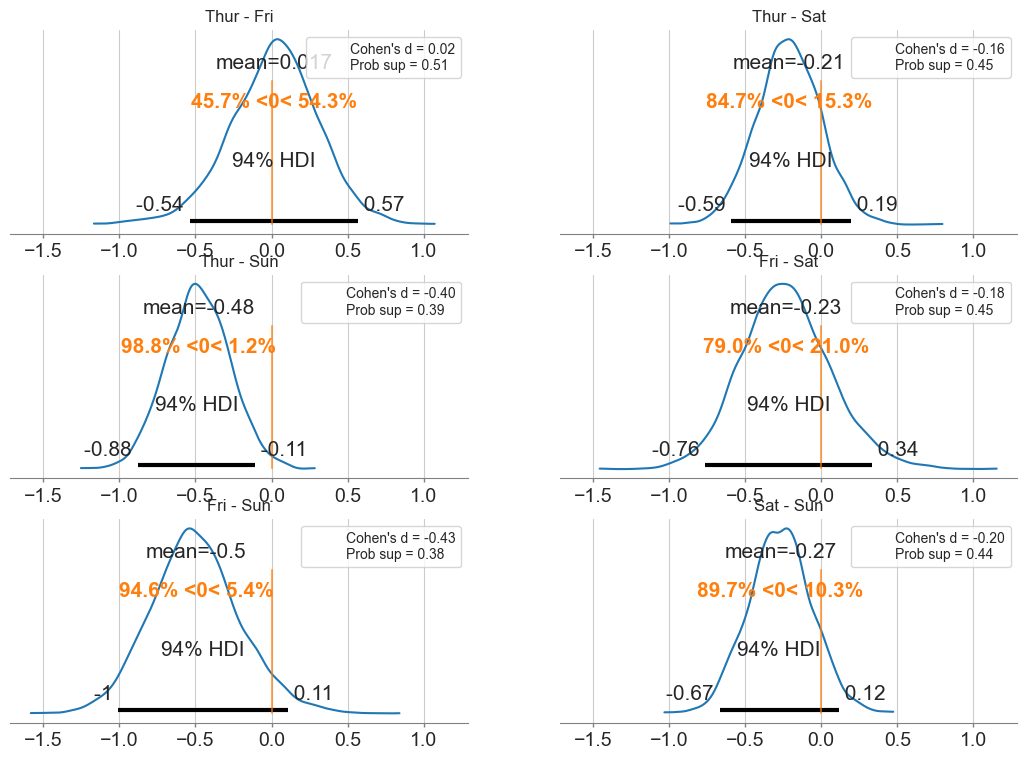

In [25]:
cg_posterior = az.extract(idata_cg)

dist = stats.norm()

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior['μ'].sel(days=i) - cg_posterior['μ'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior['σ'].sel(days=i)**2 + 
                        cg_posterior['σ'].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)

In [26]:
coords

{'days': array(['Thur', 'Fri', 'Sat', 'Sun'], dtype='<U4'),
 'days_flat': array(['Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun', 'Sun',
        'Sun', 'Sun', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Thur', 'Thur', 'Thur', 'Thur',
        'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur', 'Thur',
        'Thur', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri', 'Fri',
        'Fri', 'Fri', 'Fri', 'Fri', 'Sat', 'Sat', 'Sat', 'Sat', 'Sat',
        'Sat', 'Sat', 'Sat', 'Sat', 'Sat', 'Sun', 'Sun', 'Sun', 'Sun'